In [ ]:

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import scipy
import sklearn
import os
from scipy.signal import butter, filtfilt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report



In [ ]:
# Load EEG Data
data_folder = r"D:\dataset eeg"


npz_files = [f for f in os.listdir(data_folder) if f.endswith('.npz')]


eeg_data = {}
for file in npz_files:
    file_path = os.path.join(data_folder, file)
    data = np.load(file_path, allow_pickle=True)
    eeg_data[file] = data


first_file = npz_files[0]
print(f"Keys in {first_file}: {list(eeg_data[first_file].keys())}")


Keys in eeg-predictive_train.npz: ['train_signals', 'train_labels']


In [ ]:

train_signals_1 = eeg_data["eeg-predictive_train.npz"]["train_signals"]
train_labels_1 = eeg_data["eeg-predictive_train.npz"]["train_labels"]

train_signals_2 = eeg_data["eeg-seizure_train.npz"]["train_signals"]
train_labels_2 = eeg_data["eeg-seizure_train.npz"]["train_labels"]


train_signals = np.concatenate((train_signals_1, train_signals_2), axis=0)
train_labels = np.concatenate((train_labels_1, train_labels_2), axis=0)


print("Merged Train Signals Shape:", train_signals.shape)
print("Merged Train Labels Shape:", train_labels.shape)


Merged Train Signals Shape: (45948, 23, 256)
Merged Train Labels Shape: (45948,)


In [ ]:

seizure_indices = np.where(train_labels == 1)[0]
non_seizure_indices = np.where(train_labels == 0)[0]

seizure_sample = np.random.choice(seizure_indices, 5000, replace=False)
non_seizure_sample = np.random.choice(non_seizure_indices, 5000, replace=False)


selected_indices = np.concatenate((seizure_sample, non_seizure_sample))


train_signals_balanced = train_signals[selected_indices]
train_labels_balanced = train_labels[selected_indices]

print("Balanced Train Signals Shape:", train_signals_balanced.shape)
print("Balanced Train Labels Shape:", train_labels_balanced.shape)


unique, counts = np.unique(train_labels_balanced, return_counts=True)
print("New Label Distribution:", dict(zip(unique, counts)))

Balanced Train Signals Shape: (10000, 23, 256)
Balanced Train Labels Shape: (10000,)
New Label Distribution: {0.0: 5000, 1.0: 5000}


In [ ]:

mav = np.mean(np.abs(train_signals_balanced), axis=(1,2))

severe_threshold = np.percentile(mav, 90)  
mild_threshold = np.percentile(mav, 50)   


new_labels = []
for value in mav:
    if value >= severe_threshold:
        new_labels.append(1)  
    elif value >= mild_threshold:
        new_labels.append(2) 
    else:
        new_labels.append(0)  

train_labels_balanced = np.array(new_labels)


unique, counts = np.unique(train_labels_balanced, return_counts=True)
print("Updated Label Distribution:", dict(zip(unique, counts)))



Updated Label Distribution: {0: 5000, 1: 1000, 2: 4000}


In [ ]:

train_signals_balanced = (train_signals_balanced - np.min(train_signals_balanced)) / (np.max(train_signals_balanced) - np.min(train_signals_balanced))

print("EEG Signals After Normalization:")
print("Min:", np.min(train_signals_balanced), "Max:", np.max(train_signals_balanced))

EEG Signals After Normalization:
Min: 0.0 Max: 1.0


In [ ]:

def bandpass_filter(data, lowcut=0.5, highcut=40.0, fs=256, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=-1)


train_signals_filtered = bandpass_filter(train_signals_balanced)

print("EEG Signals After Bandpass Filtering:")
print("Shape:", train_signals_filtered.shape)

EEG Signals After Bandpass Filtering:
Shape: (10000, 23, 256)


In [ ]:
from tensorflow.keras.utils import to_categorical


train_labels_onehot = to_categorical(train_labels_balanced, num_classes=3)

print("Example of One-Hot Encoded Labels:")
print(train_labels_onehot[:5])

Example of One-Hot Encoded Labels:
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [ ]:
#2 fe-lstm mt-transformer

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, GlobalAveragePooling1D, Dropout, LayerNormalization, Add, MultiHeadAttention, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns



X = np.transpose(train_signals_filtered, (0, 2, 1))  # (num_samples, 256, 23)
print("Feature Extraction Step - Input Shape for Model:", X.shape)

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.5):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = Add()([x, inputs])
    x = LayerNormalization(epsilon=1e-6)(x)
    
    x_ff = Dense(ff_dim, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x_ff = Dropout(dropout)(x_ff)
    x_ff = Dense(inputs.shape[-1], kernel_regularizer=tf.keras.regularizers.l2(0.002))(x_ff)
    
    x = Add()([x, x_ff])
    x = LayerNormalization(epsilon=1e-6)(x)
    
    return x


input_seq = Input(shape=(256, 23), name="input_sequence")


x = LSTM(32, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.002), name="lstm_feature_extractor")(input_seq)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)


x = transformer_encoder(x, head_size=32, num_heads=2, ff_dim=32, dropout=0.5)


x = GlobalAveragePooling1D(name="global_avg_pool")(x)


x = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.002), name="dense_classifier")(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax', name="classification_output")(x)

model = Model(inputs=input_seq, outputs=output)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary(model)


X_train, X_test, y_train, y_test = train_test_split(
    X, train_labels_onehot, test_size=0.2, random_state=42, stratify=train_labels_balanced
)

early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

history = model.fit(
    X_train, y_train, epochs=30, batch_size=64, validation_split=0.2, callbacks=[early_stop, reduce_lr]
)


test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epoch')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epoch')

plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step
Classification Report:
               precision    recall  f1-score   support

           0     0.8680    0.9930    0.9263      1000
           1     0.9091    0.7000    0.7910       200
           2     0.9046    0.7937    0.8455       800

    accuracy                         0.8840      2000
   macro avg     0.8939    0.8289    0.8543      2000
weighted avg     0.8867    0.8840    0.8805      2000



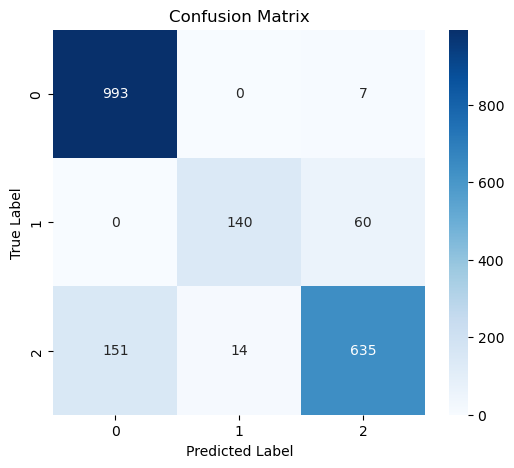

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


y_pred_probs = model.predict(X_test) 
y_pred = np.argmax(y_pred_probs, axis=1)  
y_true = np.argmax(y_test, axis=1)  


report = classification_report(y_true, y_pred, digits=4)
print("Classification Report:\n", report)


cm = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(3), yticklabels=range(3))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


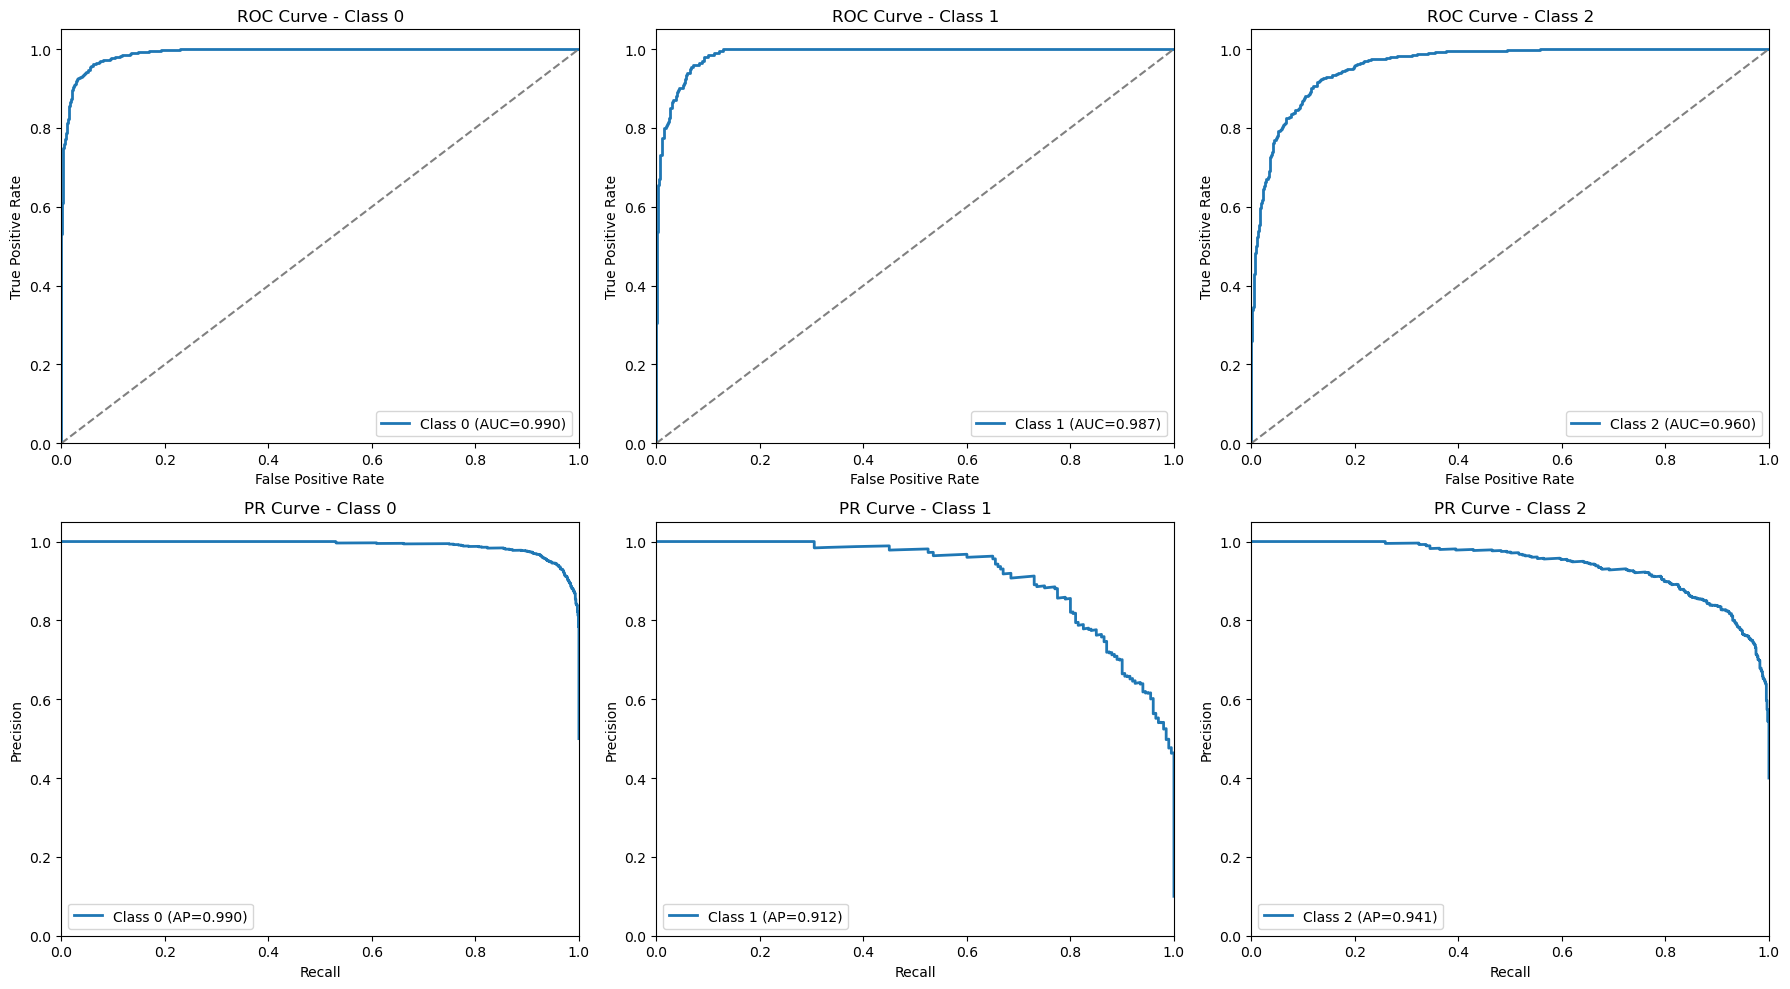

In [ ]:


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

n_classes = y_true.shape[1]


fig, axes = plt.subplots(2, n_classes, figsize=(18, 10))

roc_auc_scores = []
ap_scores = []

for i in range(n_classes):
    
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    roc_auc_scores.append(roc_auc)

    precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred_probs[:, i])
    ap = average_precision_score(y_true[:, i], y_pred_probs[:, i])
    ap_scores.append(ap)


    axes[0, i].plot(fpr, tpr, lw=2, label=f'Class {i} (AUC={roc_auc:.3f})')
    axes[0, i].plot([0, 1], [0, 1], color="gray", linestyle="--")  
    axes[0, i].set_xlim([0.0, 1.0])
    axes[0, i].set_ylim([0.0, 1.05])
    axes[0, i].set_xlabel('False Positive Rate')
    axes[0, i].set_ylabel('True Positive Rate')
    axes[0, i].set_title(f'ROC Curve - Class {i}')
    axes[0, i].legend(loc="lower right")

    axes[1, i].plot(recall, precision, lw=2, label=f'Class {i} (AP={ap:.3f})')
    axes[1, i].set_xlim([0.0, 1.0])
    axes[1, i].set_ylim([0.0, 1.05])
    axes[1, i].set_xlabel('Recall')
    axes[1, i].set_ylabel('Precision')
    axes[1, i].set_title(f'PR Curve - Class {i}')
    axes[1, i].legend(loc="lower left")


plt.tight_layout()
plt.show()
